In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import rcParams, cm
from astropy.visualization import MinMaxInterval, AsinhStretch, ImageNormalize
%matplotlib inline
from ovejero import forward_modeling, model_trainer
import os

# Comparing Performance to Forward Modeling

__Author:__ Sebastian Wagner-Carena

__Created:__ 04/01/2020

__Last Run:__ 04/01/2020

__Goals:__ Compare the performance of the BNN model to a forward modeling approach

## Forward Modeling NN1

In [3]:
root_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/'
config_path = root_path + 'configs/nn1_hr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(cfg)

fow_model = forward_modeling.ForwardModel(cfg)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5


True image without noise.


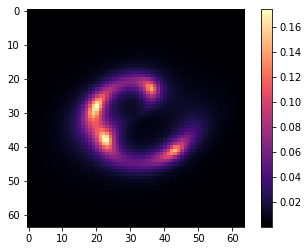

True image with noise.


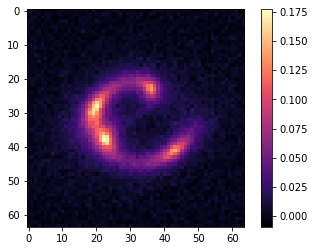

Image data
{'external_shear_dec_0': -0.04254594579306117, 'external_shear_gamma_ext': 0.05621896938274424, 'external_shear_psi_ext': -0.2187388114473809, 'external_shear_ra_0': 0.04447464276155878, 'img_filename': 'X_0000040.npy', 'lens_mass_center_x': 0.04447464276155878, 'lens_mass_center_y': -0.04254594579306117, 'lens_mass_e1': -0.0019344217722709546, 'lens_mass_e2': -0.21863827627112475, 'lens_mass_gamma': 1.7476866515467957, 'lens_mass_theta_E': 0.9779771511036928, 'src_light_R_sersic': 0.5168324861130238, 'src_light_center_x': 0.0666606974830339, 'src_light_center_y': 0.06062729637749242, 'src_light_e1': 0.2586586502764554, 'src_light_e2': -0.2979420316652591, 'src_light_magnitude': 23.24981091894046, 'src_light_n_sersic': 2.4246063799468183, 'total_magnification': 10.75538031714708}


In [4]:
# Select the image we want to forward model.
image_index = 40
fow_model.select_image(image_index)

In [6]:
# Initialize our sampler
walker_ratio = 10
save_path_chains = os.path.join(root_path,'forward_modeling/%s.h5'%(fow_model.true_values['img_filename'][:-4]))
fow_model.initialize_sampler(n_walkers,save_path_chains)

In [27]:
# And run the sampler
n_samps = 300
fow_model.run_sampler(n_samps)

  0%|          | 0/300 [00:00<?, ?it/s]

Using chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/forward_modeling/X_0000040.h5
re-using previous samples to initialize the next MCMC run.


100%|██████████| 300/300 [10:43<00:00,  2.15s/it]


Computing the MCMC...
Number of walkers =  700
Burn-in iterations:  0
Sampling iterations (in current run): 300
644.0144963264465 time taken for MCMC sampling


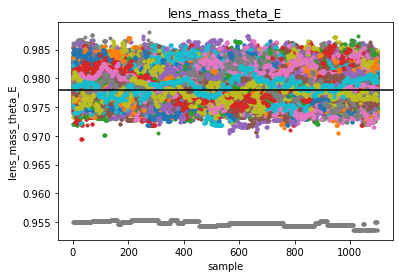

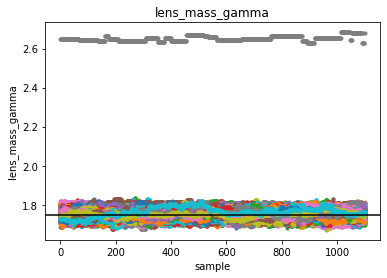

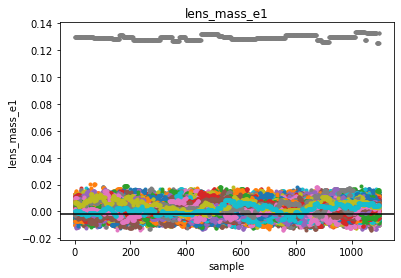

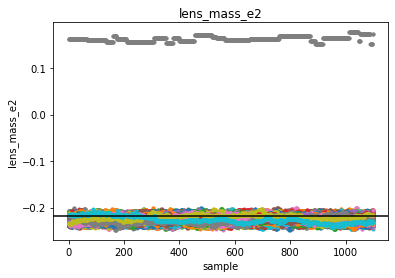

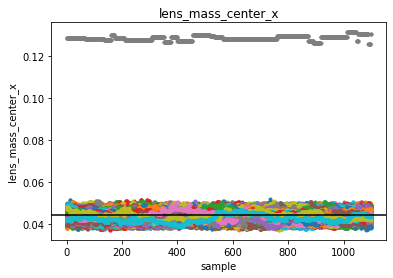

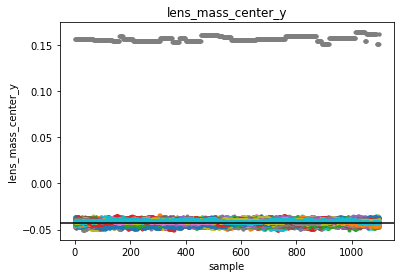

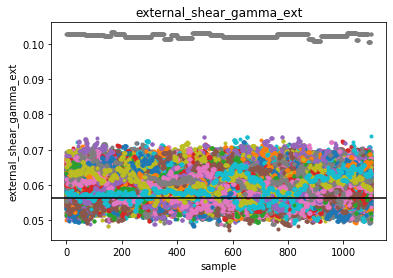

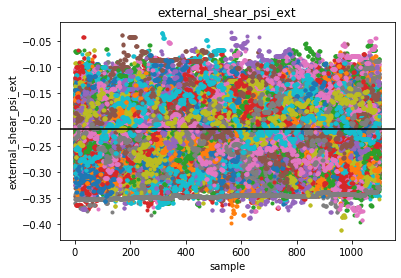

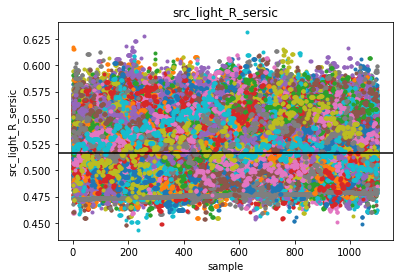

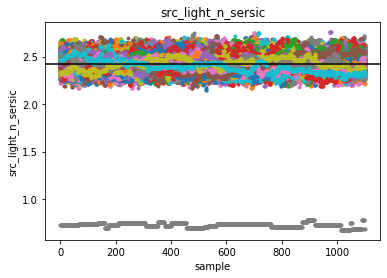

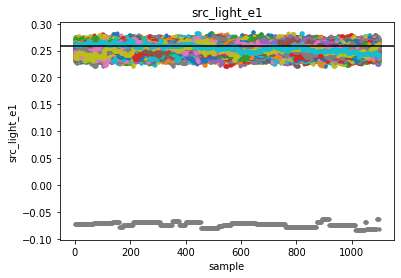

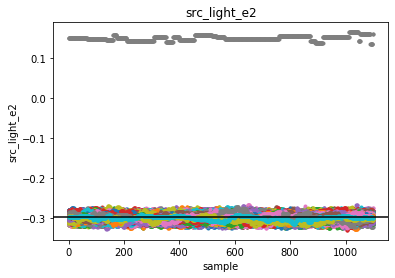

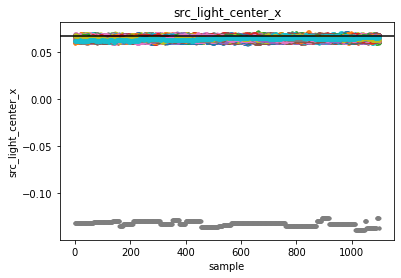

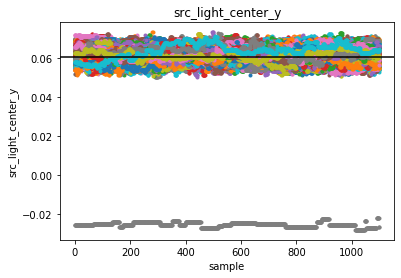

In [28]:
# Let's take a look at the chains to make sure they seem converged
burnin = 2000
fow_model.plot_chains(burnin)

In [16]:
num_samples = 1000
sample_save_dir = os.path.join(root_path,'forward_modeling/nn1_%s_samps'%(fow_model.true_values['img_filename'][:-4]))
mmd_diag = fow_model.calculate_p_MMD(burnin,num_samples,sample_save_dir=sample_save_dir)

AttributeError: 'ForwardModel' object has no attribute 'image_dict'

In [15]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
color_map = ['#000000','#1b9e77']
truth_color = '#e7298a'
plot_limits = [(0.00,0.12),(-0.08,0.04),(0.01,0.09),(-0.095,0.005),(-0.15,0.10),(-0.35,-0.10),(1.6,2.0),
              (-0.06,0.02)]
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color)

NameError: name 'num_samples' is not defined

## Forward Modeling NN2

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_lr.h5
True image without noise.


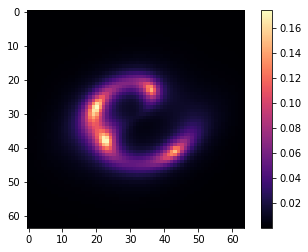

True image with noise.


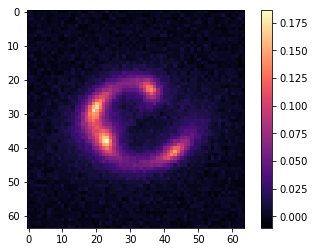

Image data
{'src_light_e2': -0.2979420316652591, 'src_light_center_y': 0.06062729637749242, 'src_light_magnitude': 23.24981091894046, 'external_shear_gamma_ext': 0.05621896938274424, 'lens_mass_e1': -0.0019344217722709546, 'src_light_n_sersic': 2.4246063799468183, 'src_light_e1': 0.2586586502764554, 'src_light_center_x': 0.0666606974830339, 'lens_mass_center_x': 0.04447464276155878, 'external_shear_psi_ext': -0.2187388114473809, 'img_filename': 'X_0000040.npy', 'src_light_R_sersic': 0.5168324861130238, 'lens_mass_center_y': -0.04254594579306117, 'lens_mass_gamma': 1.7476866515467957, 'external_shear_dec_0': -0.04254594579306117, 'external_shear_ra_0': 0.04447464276155878, 'total_magnification': 10.75538031714708, 'lens_mass_theta_E': 0.9779771511036928, 'lens_mass_e2': -0.21863827627112475}
Loaded chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5
Optimizing the following parameters:
['external_shear_gamma_ext', 'external_shear_psi_ext', 'lens_mass_center_x', 'le

In [9]:
config_path = root_path + 'configs/nn2_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

fow_model = forward_modeling.ForwardModel(cfg)
image_index = 40
fow_model.select_image(image_index)
n_walkers = 50
save_path_chains = os.path.join(root_path,'forward_modeling/%s.h5'%(fow_model.image_dict['img_filename'][:-4]))
fow_model.initialize_sampler(n_walkers,save_path_chains)

In [10]:
num_samples = 1000
sample_save_dir = os.path.join(root_path,'forward_modeling/nn2_%s_samps'%(fow_model.image_dict['img_filename'][:-4]))
mmd_full = fow_model.calculate_p_MMD(burnin,num_samples,sample_save_dir=sample_save_dir)

  0%|          | 0/1000 [00:00<?, ?it/s]

No samples found. Saving samples to /home/swagnercarena/ovejero/forward_modeling/nn2_X_0000040_samps


100%|██████████| 1000/1000 [00:41<00:00, 24.32it/s]


Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn2_X_0000040_samps


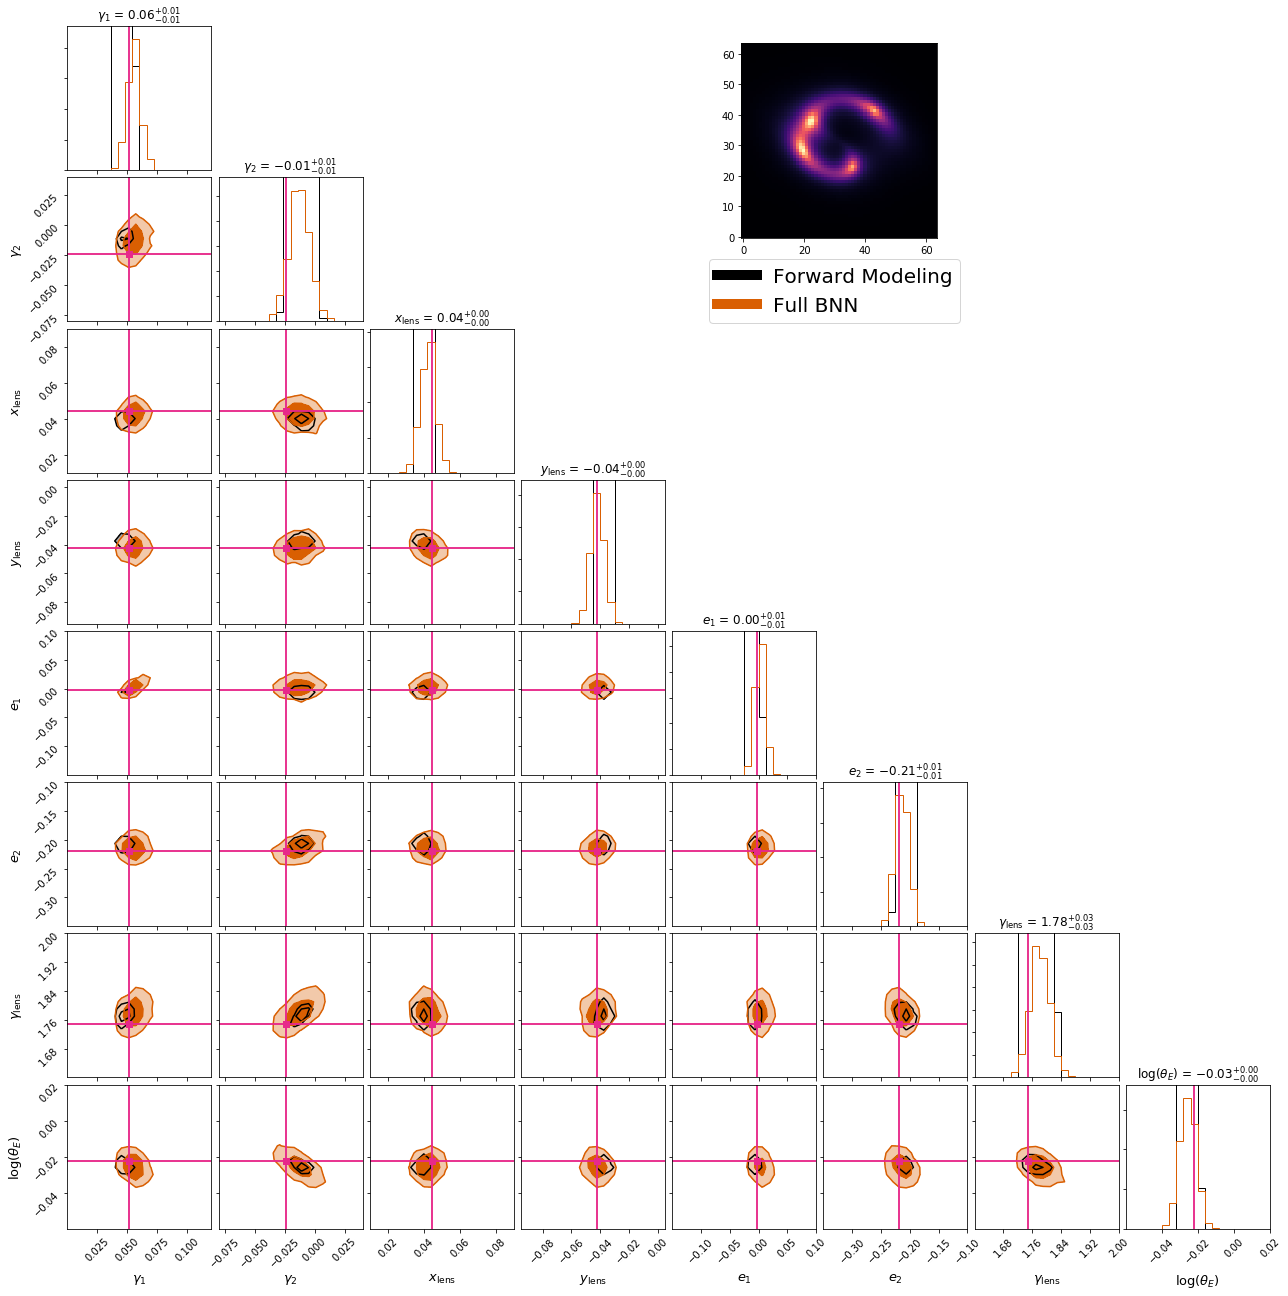

In [11]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
color_map = ['#000000','#d95f02']
truth_color = '#e7298a'
plot_limits = [(0.00,0.12),(-0.08,0.04),(0.01,0.09),(-0.095,0.005),(-0.15,0.10),(-0.35,-0.10),(1.6,2.0),
              (-0.06,0.02)]
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color)

## Forward Modeling NN3

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_lr.h5
True image without noise.


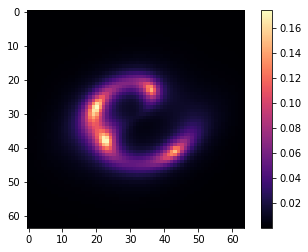

True image with noise.


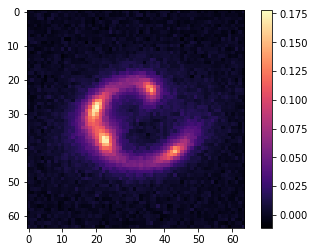

Image data
{'src_light_e2': -0.2979420316652591, 'src_light_center_y': 0.06062729637749242, 'src_light_magnitude': 23.24981091894046, 'external_shear_gamma_ext': 0.05621896938274424, 'lens_mass_e1': -0.0019344217722709546, 'src_light_n_sersic': 2.4246063799468183, 'src_light_e1': 0.2586586502764554, 'src_light_center_x': 0.0666606974830339, 'lens_mass_center_x': 0.04447464276155878, 'external_shear_psi_ext': -0.2187388114473809, 'img_filename': 'X_0000040.npy', 'src_light_R_sersic': 0.5168324861130238, 'lens_mass_center_y': -0.04254594579306117, 'lens_mass_gamma': 1.7476866515467957, 'external_shear_dec_0': -0.04254594579306117, 'external_shear_ra_0': 0.04447464276155878, 'total_magnification': 10.75538031714708, 'lens_mass_theta_E': 0.9779771511036928, 'lens_mass_e2': -0.21863827627112475}
Loaded chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5
Optimizing the following parameters:
['external_shear_gamma_ext', 'external_shear_psi_ext', 'lens_mass_center_x', 'le

In [12]:
config_path = root_path + 'configs/nn3_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

fow_model = forward_modeling.ForwardModel(cfg)
image_index = 40
fow_model.select_image(image_index)
n_walkers = 50
save_path_chains = os.path.join(root_path,'forward_modeling/%s.h5'%(fow_model.image_dict['img_filename'][:-4]))
fow_model.initialize_sampler(n_walkers,save_path_chains)

In [13]:
num_samples = 1000
sample_save_dir = os.path.join(root_path,'forward_modeling/nn3_%s_samps'%(fow_model.image_dict['img_filename'][:-4]))
mmd_gmm = fow_model.calculate_p_MMD(burnin,num_samples,sample_save_dir=sample_save_dir)

  0%|          | 0/1000 [00:00<?, ?it/s]

No samples found. Saving samples to /home/swagnercarena/ovejero/forward_modeling/nn3_X_0000040_samps


100%|██████████| 1000/1000 [00:43<00:00, 22.96it/s]


Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn3_X_0000040_samps


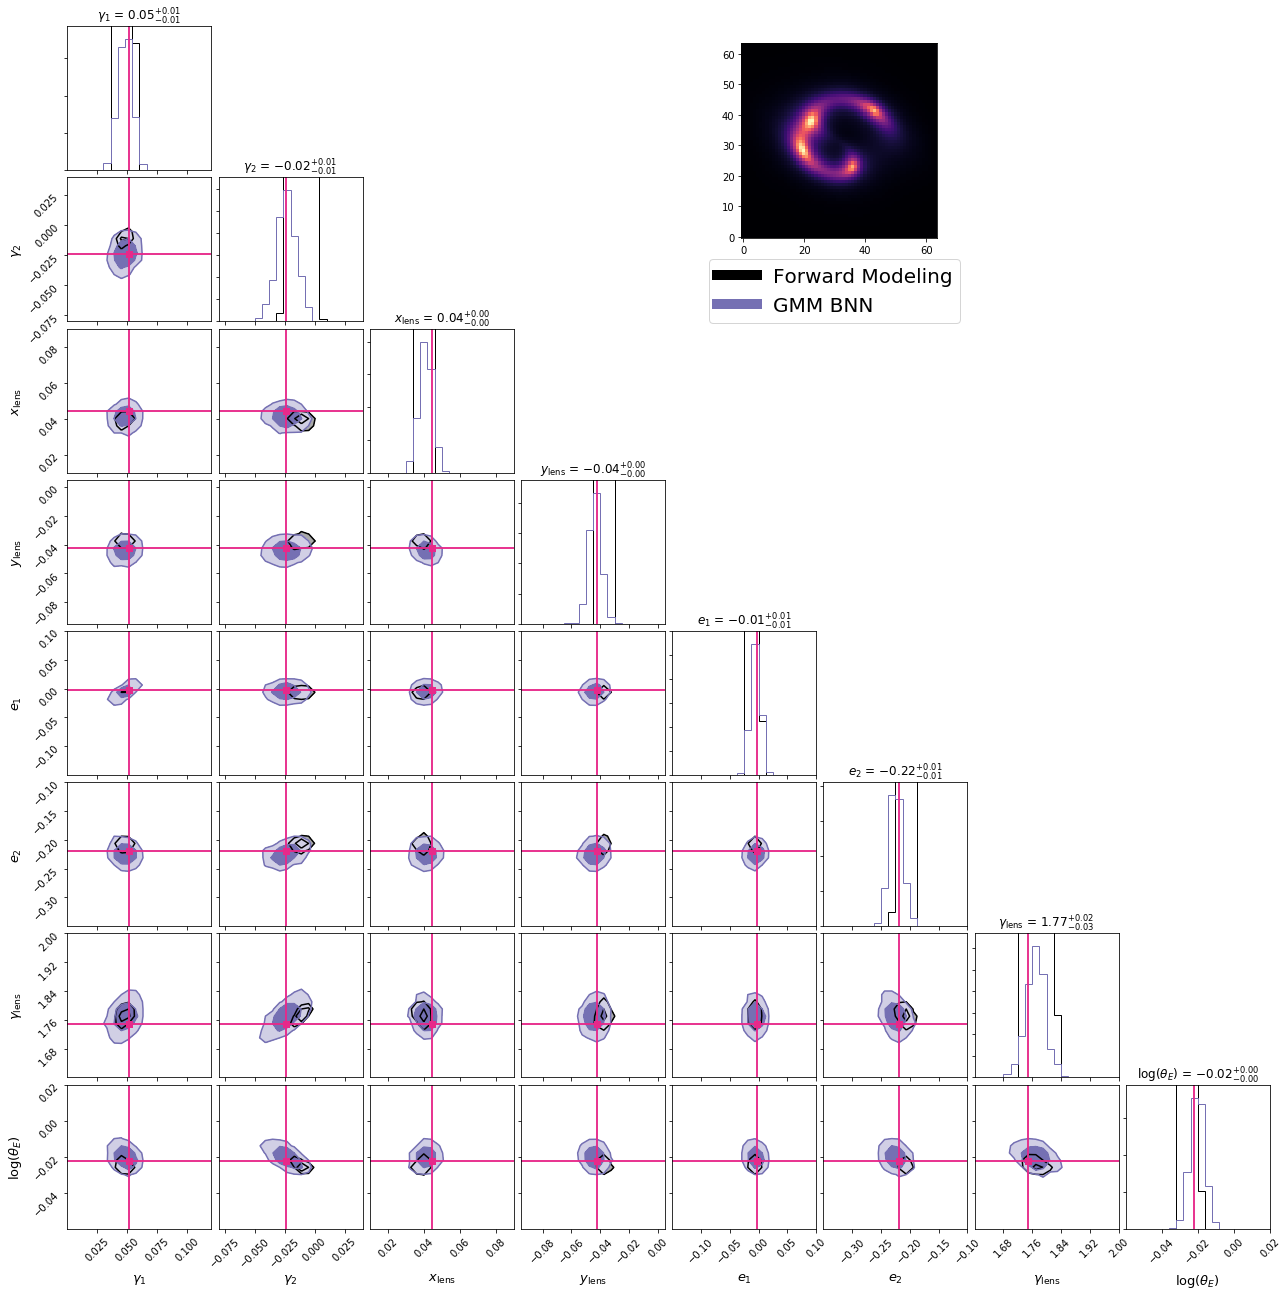

In [14]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
color_map = ['#000000','#7570b3']
truth_color = '#e7298a'
plot_limits = [(0.00,0.12),(-0.08,0.04),(0.01,0.09),(-0.095,0.005),(-0.15,0.10),(-0.35,-0.10),(1.6,2.0),
              (-0.06,0.02)]
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color)

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn3_X_0000040_samps


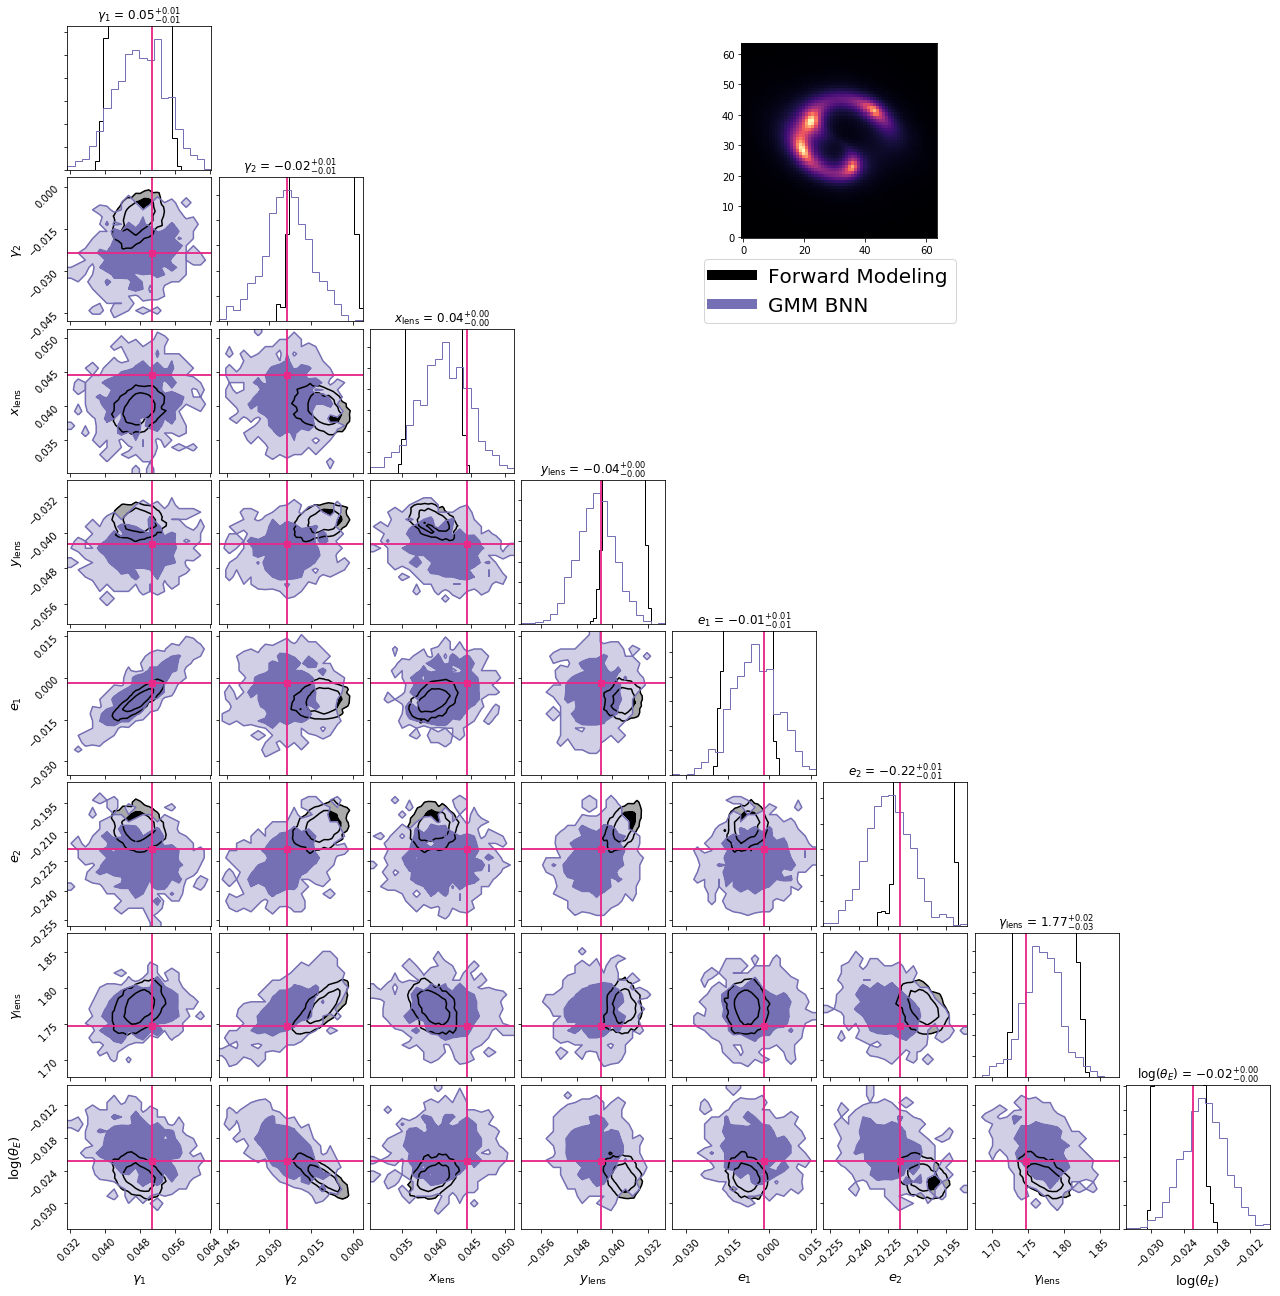

In [17]:
color_map = ['#000000','#7570b3']
truth_color = '#e7298a'
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 truth_color=truth_color)

## Comparison

In [16]:
print('Diagonal log p(MMD_u^2): %.3f'%(mmd_diag))
print('Full log p(MMD_u^2): %.3f'%(mmd_full))
print('GMMlog p(MMD_u^2): %.3f'%(mmd_gmm))

Diagonal log p(MMD_u^2): -2500888886507.595
Full log p(MMD_u^2): -2402541.666
GMMlog p(MMD_u^2): -1218783.994


## Inspect Validation Lenses

In [ ]:
# Let's print a selection of some of our validation lenses
n_columns = 5
n_images = 25
plt.figure(figsize=(n_images//n_columns*10, n_columns*9),dpi=400)
rcParams.update({'font.size': 31})
for image_index in range(1,n_images+1):
    plt.subplot(n_images//n_columns, n_columns, image_index)
    img_filename = ('X_'+'0'*(6-int(np.log10(image_index)))+str(image_index)+'.npy')
    img = np.load(os.path.join(fow_model.cfg['validation_params']['root_path'],img_filename)).astype(np.float32)
    img = fow_model.noise_function.add_noise(img).numpy()
    if image_index == 1:
        norm = ImageNormalize(img, interval=MinMaxInterval(), stretch=AsinhStretch())
    plt.imshow(np.abs(img),origin='lower',cmap=cm.magma,norm=norm)
    plt.colorbar()
plt.show()
rcParams.update({'font.size': 10})